# Tutorial 1: State Transfer
This tutorial will use the example of qubit state transfer to cover the basics of this Quantum Optimal Control package. We will be using the GRadient Ascent Pulse Engineering (GRAPE) algorithm to effect state transfer from the ground state to the excited state. 
$\newcommand{\bracket}[2]{\left\langle{#1}|{#2}\right\rangle}$

For an introduction to Quantum Optimal Control: https://qutip.org/docs/latest/guide/guide-control.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.fft import rfft, rfftfreq

In [2]:
from qoc import grape_schroedinger_discrete

## Optimization Set-up

In [3]:
total_time = 10  # pulse duration in ns
total_time_steps = 300  # number of discretized time steps
times = np.linspace(0, total_time, total_time_steps)

In [4]:
initial_state = np.array([[1, 0]])  # |0>
target_state = np.array([[0, 1]])  # |1>

### System Hamiltonian
For simplicity and ease of computation, we will work with natural units where $\hbar = 1$.

 $$\Large H =  \frac{1}{2}\omega_q\sigma_z+  u(t)\sigma_x$$

In [15]:
wq = 0.5 * 2 * np.pi  # qubit angular frequency in units of 1/ns

H0 = 0.5 * wq * np.array([[1, 0], [0, -1]])
h_controls = [np.array([[0, 1], [1, 0]])]  # list of control operators 

### Cost Function

In [16]:
from qoc.standard import TargetStateInfidelity

We difine the cost function to be minimized by the control pulse. The form of the cost function will influence the location of the minima and thus the shape of the optimized pulse. Since it is our goal to achieve a high fidelity state, the most simple cost function contains only the TargetStateInfidelity cost contribution, which depends on the fidelity($\mathcal{F}$) of the evolved state.
$$\large C = 1-\mathcal{F}$$
$$\large\mathcal{F} = \big|\bracket{\psi_{target}}{\psi_{actual}}\big|^2 $$

In [17]:
costs = [TargetStateInfidelity(target_state)]

### Initial Pulse

We must feed the optimizer an initial guess pulse to be optimized. The optimized pulse tends to maintain features of the guess pulse. For instance, if the guess is of high frequency (ex. random list of +1 and -1), the optimized pulse will also have high frequency components.

Generating high frequency signals in the lab can be challenging, so we will chose a flat pulse for our initial guess. To not show bais towards positive or negative amplitudes, it would be logical to have the pulse lie flat at 0. However, this pulse is a minimum of the cost function, so we instead choose a flat pulse which deviates slighly from 0: 

In [18]:
initial_pulse1 = [0.0001 * np.full(total_time_steps, 1)]  # the initial guess pulse to be optimized

### Run GRAPE Optimizer

In [19]:

result = grape_schroedinger_discrete(
    H0, h_controls, total_time_steps,
    costs, total_time,
    initial_state,
    initial_controls=initial_pulse1,)

iter   |   total error  |       cost0      |   grads_l2  
  0    | 1.00000000e+00 |  1.00000000e+00  |  1.65381195e-12  
  10   | 9.98236653e-01 |  9.98236653e-01  |  3.42405486e-02  
  20   | 9.88063563e-01 |  9.88063563e-01  |  8.86297841e-02  
  30   | 9.65359588e-01 |  9.65359588e-01  |  1.49236286e-01  
  40   | 9.27631069e-01 |  9.27631069e-01  |  2.11437616e-01  
  50   | 8.74096424e-01 |  8.74096424e-01  |  2.70699605e-01  
  60   | 8.05792002e-01 |  8.05792002e-01  |  3.22770104e-01  
  70   | 7.25381259e-01 |  7.25381259e-01  |  3.64119438e-01  
  80   | 6.36741839e-01 |  6.36741839e-01  |  3.92301155e-01  
  90   | 5.44418326e-01 |  5.44418326e-01  |  4.06163659e-01  
 100   | 4.53027771e-01 |  4.53027771e-01  |  4.05886553e-01  
 110   | 3.66707695e-01 |  3.66707695e-01  |  3.92841059e-01  
 120   | 2.88689643e-01 |  2.88689643e-01  |  3.69303467e-01  
 130   | 2.21057182e-01 |  2.21057182e-01  |  3.38078361e-01  
 140   | 1.64707772e-01 |  1.64707772e-01  |  3.02104168e-01

In [20]:
optimized_pulse1, infidelity1 = result.best_controls, result.best_error
print(infidelity1)

-5.551115123125783e-15


Do not be alarmed by the negative infidelity. This is an issue of machine precision and we can take the infidelity to be zero.

### Optimized Result

In [21]:
def plot_pulses(times, guess_pulse, optimized_pulse):
    plt.xlabel("time (ns)")
    plt.ylabel("u(t)")
    plt.step(times, optimized_pulse, label="optimized", color="r")
    plt.step(times, guess_pulse, label="guess", color="b")
    plt.legend()
    plt.show()

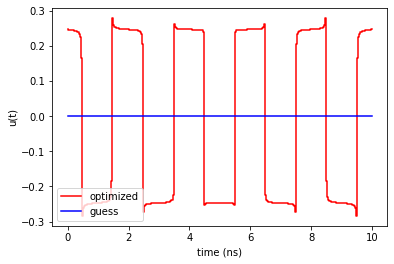

In [22]:
plot_pulses(times, initial_pulse1[0], optimized_pulse1[0])

# Smoothing the Control Pulse
This pulse above has problematic "kinks" around the maxima. These kinks can be removed with a more informed choice of cost function. We will explore two cost contributions to try to smooth this pulse. 

### Control Variation
This cost contribution will penalize high variance between adjacent control amplitudes.

In [23]:
from qoc.standard import ControlVariation

 $$\large C = 1-\mathcal{F} + \alpha C_{2}$$
$$\Large C_{2} = \sum\limits_{j}|u_j-u_{j+1}|^2 $$


We have the freedom to choose the cost multiplier($\alpha$).The buisness of setting hyperparameters can be tedious, especially when there are several cost contributions to balance. 

In [24]:
initial_pulse2 = optimized_pulse1

Instead of starting from a flat pulse like before, we can choose to start from the high fidelity, optimized pulse we just generated. The minimum of this new cost function should be "nearby" the minimum of the old cost function we found (or atleast closer than the flat pulse).

In [25]:
costs = [
    TargetStateInfidelity(target_state),
    ControlVariation( cost_multiplier=0.1, order=1),
]
def impose_bc(controls):
    controls[0][0]=0
    controls[0][-1]=0
    return controls
result = grape_schroedinger_discrete(
    H0, h_controls, total_time_steps,
    costs, total_time,
    initial_state, impose_control_conditions=impose_bc,
    initial_controls=initial_pulse1,)

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  0    | 1.00000000e+00 |  1.00000000e+00  |  2.00000000e-09  |  4.03621897e-05  
  10   | 9.96826371e-01 |  9.96751088e-01  |  7.52825454e-05  |  4.63298014e-02  
  20   | 9.84917484e-01 |  9.84514247e-01  |  4.03236965e-04  |  1.00572698e-01  
  30   | 9.61287889e-01 |  9.60209491e-01  |  1.07839793e-03  |  1.59234248e-01  
  40   | 9.23953164e-01 |  9.21766036e-01  |  2.18712812e-03  |  2.18792725e-01  
  50   | 8.72376413e-01 |  8.68626448e-01  |  3.74996548e-03  |  2.75249306e-01  
  60   | 8.07597258e-01 |  8.01828463e-01  |  5.76879434e-03  |  3.24827121e-01  
  70   | 7.32075679e-01 |  7.23891795e-01  |  8.18388436e-03  |  3.64342194e-01  
  80   | 6.49325422e-01 |  6.38415946e-01  |  1.09094756e-02  |  3.91610684e-01  
  90   | 5.63425186e-01 |  5.49605283e-01  |  1.38199031e-02  |  4.05620564e-01  
 100   | 4.78487806e-01 |  4.61715303e-01  |  1.67725030e-02  |  4.06574197e-01  
 110   | 3.98171074e-

 980   | 1.86731975e-02 |  1.82245316e-04  |  1.84909522e-02  |  1.56317624e-02  
 990   | 1.86370459e-02 |  1.81071345e-04  |  1.84559745e-02  |  1.54870183e-02  
 999   | 1.86054355e-02 |  1.80039364e-04  |  1.84253961e-02  |  1.53585201e-02  


In [26]:
optimized_pulse2, infidelity2 = result.best_controls, result.best_error

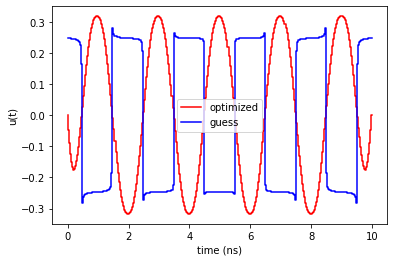

In [27]:
plot_pulses(times, initial_pulse2[0], optimized_pulse2[0])

### Control Bandwidth

It can also be helpful to consider the frequency representation of our pulse. This time we will smooth the kinks by manipulating the frequencies of the puslse rather than the aplitudes

In [28]:
def plot_fft(pulse, n):
    # calculate the list of FFT amplitudes
    fourier = np.abs(rfft(pulse))
    # create a list of frequency bins
    freq = rfftfreq(total_time_steps, total_time / total_time_steps)

    plt.stem(freq, fourier, markerfmt=" ")
    plt.ylabel("FFT Amplitude")
    plt.xlabel("frequency (1/ns)")

    # label the n most populated frequencies
    max_index = np.argpartition(abs(fourier), -n)[-n:]
    for index in max_index:
        plt.annotate("{}".format(freq[index]), xy=(freq[index], fourier[index]))

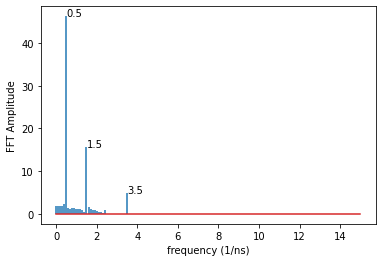

In [51]:
plot_fft(optimized_pulse3[0], 3)

To target the high frequency "kinks" we will add the ControlBandwidthMax cost contribution which penalizes frequencies above a specified cutoff frequency, "max_bandwidths".

In [58]:
from qoc.standard import ControlBandwidthMax

 $$\large C = 1-\mathcal{F} + \alpha C_{3}(\omega_{max})$$


To remove the high frequency components, set the cuttoff frequency just above the qubit frequency of 0.5 1/ns.
Here, we first filter high frequency.

In [ ]:
costs = [
    TargetStateInfidelity(target_state),
    ControlBandwidthMax(
        dt = total_time/total_time_steps,
        max_bandwidths=np.array([[0,0.6]]),
        cost_multiplier=0.001,
    ),
]
def impose_bc(controls):
    controls[0][0]=0
    controls[0][-1]=0
    return controls
result = grape_schroedinger_discrete(
    H0, h_controls, total_time_steps,
    costs, total_time,
    initial_state, impose_control_conditions=impose_bc, iteration_count = 1500,
    initial_controls=initial_pulse2,)

Then, we filter the low-frenquency components

In [76]:
costs = [
    TargetStateInfidelity(target_state),
    ControlBandwidthMax(
        dt = total_time/total_time_steps,
        max_bandwidths=np.array([[0.4,0.6]]),
        cost_multiplier=0.001,
    ),
]
def impose_bc(controls):
    controls[0][0]=0
    controls[0][-1]=0
    return controls
result = grape_schroedinger_discrete(
    H0, h_controls, total_time_steps,
    costs, total_time,
    initial_state, impose_control_conditions=impose_bc, iteration_count = 500,
    initial_controls=result.best_controls,)

iter   |   total error  |       cost0      |       cost1      |   grads_l2  
  0    | 1.11360850e-01 |  1.77590559e-03  |  1.09584945e-01  |  2.98640109e-01  
  10   | 1.11222746e-01 |  1.66500563e-03  |  1.09557740e-01  |  2.97962022e-01  
  20   | 1.09929409e-01 |  1.67807672e-03  |  1.08251332e-01  |  2.97749393e-01  
  30   | 1.08614680e-01 |  1.79049433e-03  |  1.06824186e-01  |  2.97841220e-01  
  40   | 1.07456770e-01 |  1.92280732e-03  |  1.05533963e-01  |  2.97962778e-01  
  50   | 1.06389431e-01 |  2.01971352e-03  |  1.04369717e-01  |  2.98100600e-01  
  60   | 1.05404779e-01 |  2.06904446e-03  |  1.03335735e-01  |  2.98224222e-01  
  70   | 1.04406040e-01 |  2.11978463e-03  |  1.02286256e-01  |  2.98071833e-01  
  80   | 1.03409436e-01 |  2.19452117e-03  |  1.01214915e-01  |  2.98253019e-01  
  90   | 1.02480116e-01 |  2.23503852e-03  |  1.00245078e-01  |  2.98207588e-01  
 100   | 1.01476207e-01 |  2.26187953e-03  |  9.92143272e-02  |  2.98139888e-01  
 110   | 1.00493773e-

In [77]:
optimized_pulse3, infidelity3 = result.best_controls, result.best_error
print(infidelity3)

0.09431032360332457


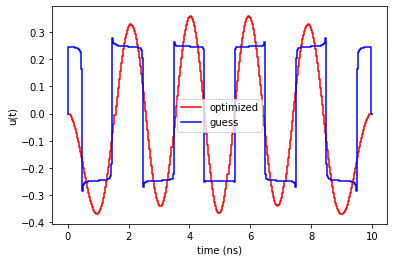

In [78]:
plot_pulses(times, initial_pulse2[0], optimized_pulse3[0])

Pulse is much smoother. If we want to furthermore reduce the bandwidth, we need use some tricks. The example of tricks is on the way.